In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# "sigmoid cross entropy with logits" in lab material
from torch.nn.functional import binary_cross_entropy_with_logits as bincre_wlogits

import torchvision
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
torch.manual_seed(1)

import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

In [3]:
# Random sample
def sample_Z(m, n):
    return torch.randn(m, n)

# Re-implement function used in resources 
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / (in_dim / 2.)**0.5  # Using standard Python sqrt calculation
    return torch.randn(*size) * xavier_stddev

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([784, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 1]))
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.relu(x @ self.W1 + self.b1)
        logits = x @ self.W2 + self.b2
        prob = torch.sigmoid(logits)
        return prob, logits


class Generator(nn.Module):
    def __init__(self, zdim):
        super(Generator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([zdim, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 784]))
        self.b2 = nn.Parameter(torch.zeros(784))

    def forward(self, z):
        z2 = torch.relu(z @ self.W1 + self.b1)
        log_prob = z2 @ self.W2 + self.b2
        prob = torch.sigmoid(log_prob)
        return prob

In [5]:
m = 50
zdim = 100

def train(iterations, loss_criterion="", no_printouts=4, no_samples=5):
    generator = Generator(zdim=zdim)
    discriminator = Discriminator()
    D_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.001)
    G_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.001)
    train_loader = DataLoader(train_set, batch_size=m, shuffle=True)

    d_history = []
    g_history = []
    torch.autograd.set_detect_anomaly(True) # for .backward tracing debugging
    assert (iterations/no_printouts) % 2 == 0, "iterations/no_printouts has to be even"

    print(f"m: {m}, zdim: {zdim}")
    if loss_criterion == "logistic":
        print("Running with logistic loss")
    
    for it in range(iterations):
        
        # Update discriminator
        # Note: due to training limitations, always run at k=1
        (batch_images, batch_label)  = next(iter(train_loader))
        batch_images = batch_images.view(batch_images.size(0), -1)  # Flatten the image tensor if needed
        Z = sample_Z(m, zdim)  # Sample noise

        D_optimizer.zero_grad()
        x = generator(Z)
        D_real, D_logit_real = discriminator(batch_images)
        D_fake, D_logit_fake = discriminator(x)    

        if loss_criterion == "logistic":
            D_loss_real = torch.mean(bincre_wlogits(D_logit_real, torch.ones_like(D_logit_real)))
            D_loss_fake = torch.mean(bincre_wlogits(D_logit_fake, torch.zeros_like(D_logit_fake)))
            D_loss = D_loss_real + D_loss_fake
        else:
            D_loss = -torch.mean(torch.log(D_real) + torch.log(torch.ones(D_fake.shape) - D_fake))

        D_loss.backward(retain_graph=True)
        D_optimizer.step()
            

        # Update generator
        G_Z = sample_Z(m, zdim)  # Sample noise
        G_optimizer.zero_grad()
        G_img_fake = generator(G_Z)
        G_fake, G_logit_fake = discriminator(G_img_fake)
        
        if loss_criterion == "logistic":
            G_loss = torch.mean(bincre_wlogits(G_logit_fake, torch.ones_like(G_logit_fake)))
        else:
            G_loss = torch.nn.functional.binary_cross_entropy(G_fake, torch.ones_like(G_fake))

        G_loss.backward(retain_graph=True)
        G_optimizer.step()

        
        # Printouts + history
        d_history.append(D_loss.item())
        g_history.append(G_loss.item())
        if it % (iterations/no_printouts) == 0:
            print(f"Iteration {it}: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
            r = m if m < no_samples else no_samples
            fig, axes = plt.subplots(1, r, figsize=(r, 1), sharex=True, sharey=True)
            for ri in range(r):
                G_img = G_img_fake[ri].detach()
                G_img = torch.reshape(G_img, [28,28])
                axes[ri].imshow(G_img, cmap='gray')
                axes[ri].axis('off')
            plt.show()

    print(f"Final: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
    plt.plot(d_history, label="Discriminator loss")
    plt.plot(g_history, label="Generator loss")
    plt.legend()
    plt.show()

    return discriminator, generator

m: 50, zdim: 100
Iteration 0: D_loss 1.6165345907211304, G_loss 2.1174912452697754


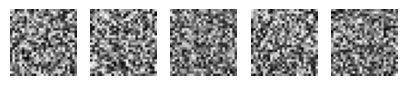

Iteration 25000: D_loss 0.7255260944366455, G_loss 2.1014742851257324


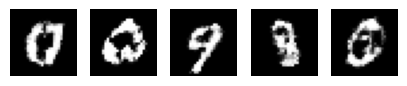

Iteration 50000: D_loss 0.6884092092514038, G_loss 2.0942037105560303


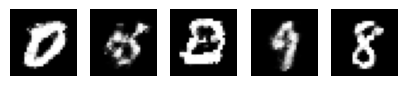

Iteration 75000: D_loss 0.5987367630004883, G_loss 2.276399612426758


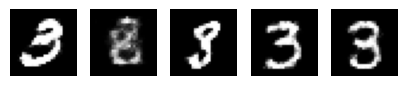

Final: D_loss 0.6259672045707703, G_loss 2.1443886756896973


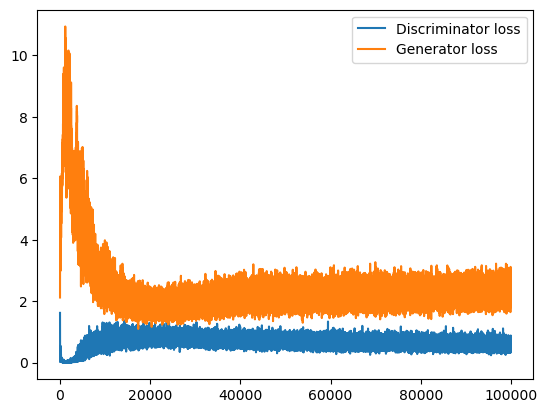

In [12]:
D11, G11 = train(iterations=100_000)


Here we can see how it slowly improves during its run but later stagnates, and how the generator seems to be doing worse it probebly just discrimnator is finding patters.

m: 50, zdim: 100
Running with logistic loss
Iteration 0: D_loss 1.1676756143569946, G_loss 2.859257459640503


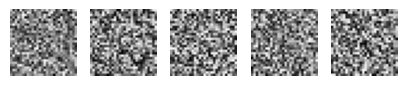

Iteration 5000: D_loss 0.1530311107635498, G_loss 4.958594799041748


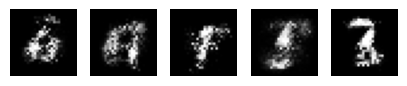

Iteration 10000: D_loss 0.9314088821411133, G_loss 2.414170265197754


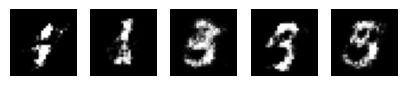

Iteration 15000: D_loss 0.5272461771965027, G_loss 2.074899673461914


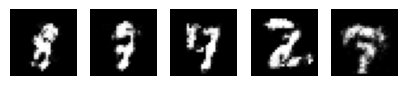

Final: D_loss 0.7749460339546204, G_loss 2.3471035957336426


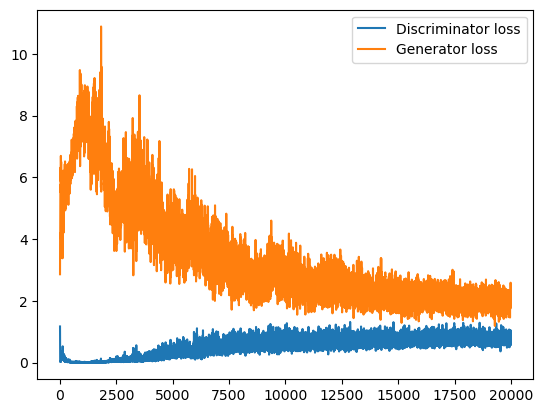

m: 50, zdim: 100
Running with logistic loss
Iteration 0: D_loss 1.103595495223999, G_loss 2.963552951812744


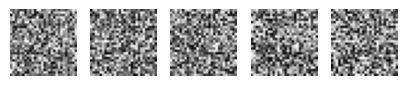

Iteration 25000: D_loss 0.5412614941596985, G_loss 2.4859282970428467


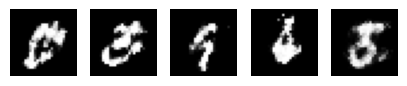

Iteration 50000: D_loss 0.7700595259666443, G_loss 2.2324814796447754


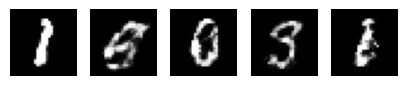

Iteration 75000: D_loss 0.5401952862739563, G_loss 2.638662099838257


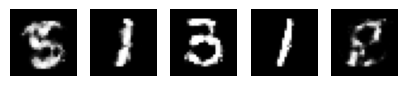

Final: D_loss 0.4509541094303131, G_loss 2.9891748428344727


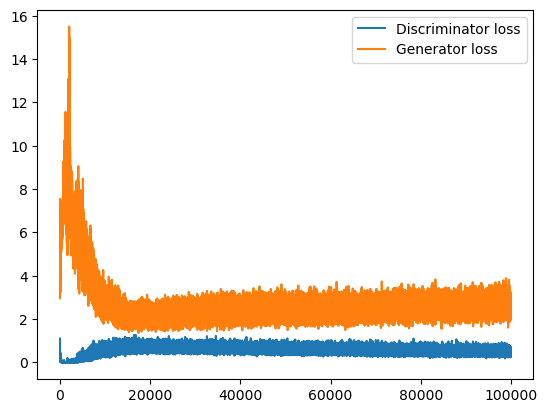

In [11]:
D21, G21 = train(iterations=20_000, loss_criterion="logistic")
D22, G22 = train(iterations=100_000, loss_criterion="logistic")

This seems to be doing slightly worse then the Binary cross entropy, but they look fairly similar. 

In [6]:
class Generator(nn.Module):
    def __init__(self, zdim):
        super(Generator, self).__init__()
        self.zdim = zdim
        self.n_classes = 10  # Assuming 10 classes for MNIST
        self.W1 = nn.Parameter(xavier_init([zdim + self.n_classes, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 784]))
        self.b2 = nn.Parameter(torch.zeros(784))

    def forward(self, z, labels):
        z = torch.cat([z, labels], 1)  # Concatenate labels to the noise vector
        z2 = torch.relu(z @ self.W1 + self.b1)
        log_prob = z2 @ self.W2 + self.b2
        prob = torch.sigmoid(log_prob)
        return prob

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_classes = 10  # Assuming 10 classes for MNIST
        self.W1 = nn.Parameter(xavier_init([784 + self.n_classes, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 1]))
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x, labels):
        x = torch.cat([x, labels], 1)  # Concatenate labels to the image vector
        x = torch.relu(x @ self.W1 + self.b1)
        logits = x @ self.W2 + self.b2
        prob = torch.sigmoid(logits)
        return prob, logits


In [7]:
m = 50
zdim = 100

def train(iterations, loss_criterion="", no_printouts=4, no_samples=5):
    generator = Generator(zdim=zdim)
    discriminator = Discriminator()
    D_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.001)
    G_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.001)
    train_loader = DataLoader(train_set, batch_size=m, shuffle=True)

    d_history = []
    g_history = []
    torch.autograd.set_detect_anomaly(True) # for .backward tracing debugging
    assert (iterations/no_printouts) % 2 == 0, "iterations/no_printouts has to be even"

    print(f"m: {m}, zdim: {zdim}")
    if loss_criterion == "logistic":
        print("Running with logistic loss")
    
    for it in range(iterations):
        
        # Update discriminator
        # Note: due to training limitations, always run at k=1
        (batch_images, batch_label)  = next(iter(train_loader))
        batch_images = batch_images.view(batch_images.size(0), -1)  # Flatten the image tensor if needed
        Z = sample_Z(m, zdim)  # Sample noise

        # One-hot encode the labels
        labels = F.one_hot(batch_label, num_classes=10).float()

        D_optimizer.zero_grad()
        x = generator(Z, labels)
        D_real, D_logit_real = discriminator(batch_images, labels)
        D_fake, D_logit_fake = discriminator(x, labels)

        if loss_criterion == "logistic":
            D_loss_real = torch.mean(bincre_wlogits(D_logit_real, torch.ones_like(D_logit_real)))
            D_loss_fake = torch.mean(bincre_wlogits(D_logit_fake, torch.zeros_like(D_logit_fake)))
            D_loss = D_loss_real + D_loss_fake
        else:
            D_loss = -torch.mean(torch.log(D_real) + torch.log(torch.ones(D_fake.shape) - D_fake))

        D_loss.backward(retain_graph=True)
        D_optimizer.step()
            

        # Update generator
        G_Z = sample_Z(m, zdim)  # Sample noise
        G_optimizer.zero_grad()
        G_img_fake = generator(G_Z, labels)
        G_fake, G_logit_fake = discriminator(G_img_fake, labels)

        if loss_criterion == "logistic":
            G_loss = torch.mean(bincre_wlogits(G_logit_fake, torch.ones_like(G_logit_fake)))
        else:
            G_loss = torch.nn.functional.binary_cross_entropy(G_fake, torch.ones_like(G_fake))

        G_loss.backward(retain_graph=True)
        G_optimizer.step()

        
        # Printouts + history
        d_history.append(D_loss.item())
        g_history.append(G_loss.item())
        if it % (iterations/no_printouts) == 0:
            print(f"Iteration {it}: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
            r = m if m < no_samples else no_samples
            fig, axes = plt.subplots(1, r, figsize=(r, 1), sharex=True, sharey=True)
            for ri in range(r):
                G_img = G_img_fake[ri].detach()
                G_img = torch.reshape(G_img, [28,28])
                axes[ri].imshow(G_img, cmap='gray')
                axes[ri].axis('off')
            plt.show()

    print(f"Final: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
    plt.plot(d_history, label="Discriminator loss")
    plt.plot(g_history, label="Generator loss")
    plt.legend()
    plt.show()

    return discriminator, generator

m: 50, zdim: 100
Iteration 0: D_loss 1.4640692472457886, G_loss 2.279775619506836


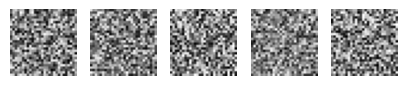

Iteration 25000: D_loss 0.8206416964530945, G_loss 1.6281843185424805


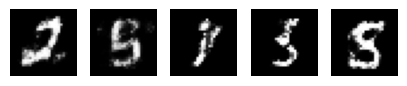

Iteration 50000: D_loss 0.9685819745063782, G_loss 1.6697824001312256


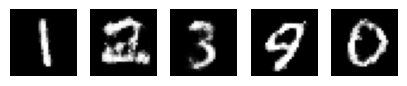

Iteration 75000: D_loss 0.7748472690582275, G_loss 1.9061757326126099


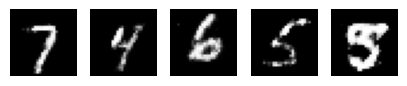

Final: D_loss 0.8668351173400879, G_loss 1.8873618841171265


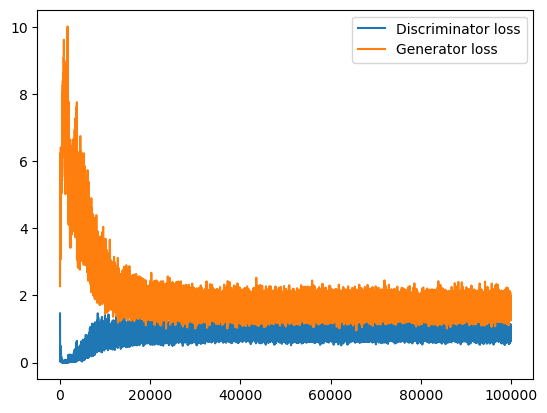

In [8]:
D11, G11 = train(iterations=100_000)

Thhis one look better not alot but still better.

In [21]:
def generate_and_print(generator, label, no_samples=5):
    r = no_samples
    label
    fig, axes = plt.subplots(1, r, figsize=(r, 1), sharex=True, sharey=True)

    # Generate noise and labels for '9'
    G_Z = sample_Z(r, zdim) # Sample noise
    labels = torch.zeros((r, 10))  # Create a tensor of zeros with shape (r, 10)
    labels[:, label] = 1  # Set the column corresponding to 'label' to 1

    G_img_fake = generator(G_Z, labels)  # Generate images for 'label'

    for ri in range(r):
        G_img = G_img_fake[ri].detach()
        G_img = torch.reshape(G_img, [28,28])
        axes[ri].imshow(G_img.cpu(), cmap='gray')
        axes[ri].axis('off')
    plt.show()

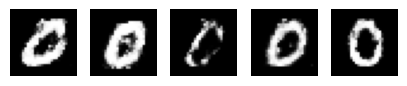

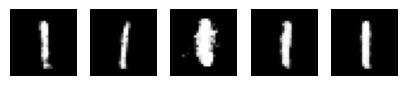

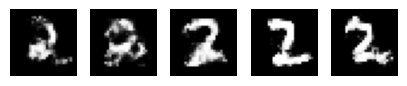

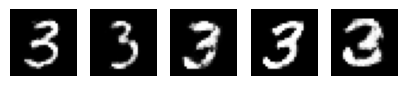

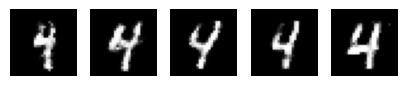

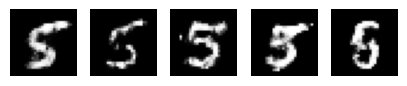

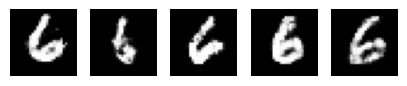

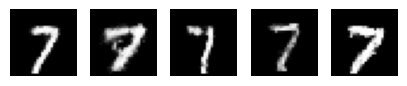

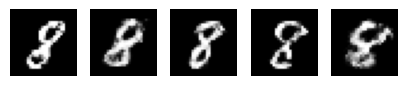

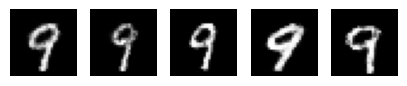

In [25]:
for i in range(10):
    generate_and_print(G11, i)




Though here when checking it looks alot better.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN architecture
def train_model(model, train_loader, device, learning_rate=0.001, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    print('Finished Training')
    return model

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Initialize the model, device, and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitCNN().to(device)
model = train_model(model, train_loader, device)model.eval()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 6704326.02it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 261246.22it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2057883.31it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2570921.56it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw


C:\Users\unm30\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 0.20681126668492256
Epoch 2, Loss: 0.0895534285874382
Epoch 3, Loss: 0.06996304870507161
Epoch 4, Loss: 0.05636974586224033
Epoch 5, Loss: 0.05098023440918204
Epoch 6, Loss: 0.04272467975795983
Epoch 7, Loss: 0.037214741974422184
Epoch 8, Loss: 0.034157956078740906
Epoch 9, Loss: 0.031051943387640373
Epoch 10, Loss: 0.029216296979314788
Finished Training


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28 * 28)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = x.view(-1, 1, 28, 28)
        return x

In [12]:
generator = Generator().to(device)

# Define the adversarial training function
def adversarial_training(generator, model, target_label, epochs, epsilon, device, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        generator.train()
        running_loss = 0.0
        
        for _ in range(100):  # Generate 100 adversarial examples per epoch
            # Generate random noise
            noise = torch.randn(64, 100).to(device)
            
            # Generate adversarial images
            adversarial_images = generator(noise)
            
            # Target labels
            target = torch.full((64,), target_label, dtype=torch.long, device=device)
            
            # Forward pass through the CNN
            output = model(adversarial_images)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / 100}")
    
    print('Finished Adversarial Training')

# Set target label (e.g., 9), epsilon, and learning rate
target_label = 9
epsilon = 0.1
learning_rate = 0.001
epochs = 10

# Train the generator to create adversarial examples
adversarial_training(generator, model, target_label, epochs, epsilon, device, learning_rate)


Epoch 1, Loss: 0.07379143631058582
Epoch 2, Loss: 0.00011298638520969462
Epoch 3, Loss: 2.7964689564328183e-05
Epoch 4, Loss: 5.518725162222182e-05
Epoch 5, Loss: 0.00014248494889603335
Epoch 6, Loss: 0.0001643875610984935
Epoch 7, Loss: 4.225072647898287e-05
Epoch 8, Loss: 0.00013275865851687386
Epoch 9, Loss: 0.00016531055462511103
Epoch 10, Loss: 2.121500851394842e-05
Finished Adversarial Training


In [13]:
generator = Generator().to(device)

# Define the adversarial training function
def adversarial_training(generator, model, target_label, epochs, epsilon, device, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        generator.train()
        running_loss = 0.0
        
        for _ in range(100):  # Generate 100 adversarial examples per epoch
            # Generate random noise
            noise = torch.randn(64, 100).to(device)
            
            # Generate adversarial images
            adversarial_images = generator(noise)
            
            # Target labels
            target = torch.full((64,), target_label, dtype=torch.long, device=device)
            
            # Forward pass through the CNN
            output = model(adversarial_images)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / 100}")
    
    print('Finished Adversarial Training')

# Set target label (e.g., 9), epsilon, and learning rate
target_label = 9
epsilon = 0.1
learning_rate = 0.001
epochs = 10

# Train the generator to create adversarial examples
adversarial_training(generator, model, target_label, epochs, epsilon, device, learning_rate)

Epoch 1, Loss: 0.07760718002774411
Epoch 2, Loss: 6.311550164689095e-05
Epoch 3, Loss: 0.00043099613922535694
Epoch 4, Loss: 0.00014497104379458393
Epoch 5, Loss: 6.951967583518126e-05
Epoch 6, Loss: 4.6656594775953405e-05
Epoch 7, Loss: 5.371058051309774e-05
Epoch 8, Loss: 0.00011906217215710058
Epoch 9, Loss: 0.0005031822286920829
Epoch 10, Loss: 0.00014006196779817515
Finished Adversarial Training


In [14]:
def generate_random_noise_images(batch_size, image_size):
    return torch.clamp(torch.randn(batch_size, 1, image_size, image_size), 0, 1).to(device)

# Generate adversarial images
noise = torch.randn(64, 100).to(device)
adversarial_images = generator(noise)

# Test adversarial images on the model
model.eval()
output_adv = model(adversarial_images)
preds_adv = torch.argmax(output_adv, dim=1)
print(f"Adversarial predictions: {preds_adv}")

# Generate and test random noise images
random_noise_images = generate_random_noise_images(64, 28)
output_noise = model(random_noise_images)
preds_noise = torch.argmax(output_noise, dim=1)
print(f"Random noise predictions: {preds_noise}")

# Compare the two sets of images
for i in range(len(adversarial_images)):
    print(f"Adversarial: {preds_adv[i]}, Random Noise: {preds_noise[i]}")

Adversarial predictions: tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
Random noise predictions: tensor([7, 2, 7, 2, 8, 7, 2, 2, 7, 7, 3, 6, 6, 2, 6, 2, 2, 2, 2, 7, 2, 2, 7, 7,
        7, 2, 2, 7, 7, 2, 1, 2, 2, 2, 6, 5, 2, 7, 2, 2, 2, 2, 2, 6, 7, 2, 2, 2,
        2, 5, 8, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 7, 6, 8], device='cuda:0')
Adversarial: 9, Random Noise: 7
Adversarial: 9, Random Noise: 2
Adversarial: 9, Random Noise: 7
Adversarial: 9, Random Noise: 2
Adversarial: 9, Random Noise: 8
Adversarial: 9, Random Noise: 7
Adversarial: 9, Random Noise: 2
Adversarial: 9, Random Noise: 2
Adversarial: 9, Random Noise: 7
Adversarial: 9, Random Noise: 7
Adversarial: 9, Random Noise: 3
Adversarial: 9, Random Noise: 6
Adversarial: 9, Random Noise: 6
Adversarial: 9, Random Noise: 2
Adversarial: 9, Random Noise: 6
A